# Complex-Number Representation Link Prediction

The Complex Representation-based Link Prediction (CORLP) method predicts links between users and items by modelling relational dualities using complex numbers. By using complex numbers, the algorithm can distinguish between different types of relationships. More specifically, the similar or dissimilar links between users or items are weighted by real numbers, while the like or dislike links between users and items are weighted by complex numbers.

This is an implementation of CORLP in the context of music recommendation.

In [27]:
import numpy  as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power

import warnings
warnings.filterwarnings("ignore")


## Data Preprocessing

The data preprocessing includes filling the weights of the unrated tracks, splitting the dataframe is train/test set and creating the adjacency matrix.

In [28]:
# import the data
dataset_path = "../data/spotify_million_playlist_dataset/playlist_track_mapping_unweighted.txt"

columns = ['playlistId', 'trackId', 'weight']

df = pd.read_csv(dataset_path, 
                sep=' ',
                names=columns, 
                low_memory=False,  
                encoding="latin-1")
df.head() # check the format

,playlistId,trackId,weight
0,202269201444,718638038900,1
1,202269201444,522103160601,1
2,202269201444,808916200056,1
3,202269201444,602509086965,1
4,202269201444,635033516226,1


In [29]:
# chose a subset of the initial data between the size of 100 to 200000
df = df.iloc[:22500,:] # 19500

In [30]:
number_of_playlists = df.playlistId.unique().size
number_of_tracks  = df.trackId.unique().size

print(f"{number_of_playlists} playlists (users) containing {number_of_tracks} songs")

343 playlists (users) containing 14295 songs


In [31]:
# train - test split
df_train, df_test  = train_test_split(df, test_size=0.3, random_state=42)

# drop duplicate entries in df_train
df_train = df_train.drop_duplicates(['playlistId', 'trackId'])

# fill the weight/preference of unrated tracks with 0
df_user_item = df_train.pivot(index='playlistId', columns='trackId', values='weight').fillna(0)

# convert to NumPy array
ui = np.array(df_user_item)

In [32]:
df_user_item.head()

trackId,299507032,512219278,564370655,646511383,681992252,715610175,728801012,859323870,903366882,923225647,...,998940007450,998999433525,999018537321,999031286637,999065428356,999304472220,999417025468,999482818991,999731325071,999990448993
playlistId,,,,,,,,,,,,,,,,,,,,,
3174342715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8229843960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8815090205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12492377828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14053753232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Complex Numbers

Elements in df_Aui that greater than 0 and less than the threshold are set to -1j to express whether a user likes item or item dislikes user, while element with values greater than the threshold express if a user dislikes an item or an item likes user.


In [33]:
threshold = 1

df_Aui = df_user_item.copy()

df_Aui[(0 < df_user_item) & (df_user_item < threshold)] = -1j
df_Aui[ df_user_item >= threshold ] = 1j

df_Aui.head()

trackId,299507032,512219278,564370655,646511383,681992252,715610175,728801012,859323870,903366882,923225647,...,998940007450,998999433525,999018537321,999031286637,999065428356,999304472220,999417025468,999482818991,999731325071,999990448993
playlistId,,,,,,,,,,,,,,,,,,,,,
3174342715,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
8229843960,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
8815090205,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
12492377828,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
14053753232,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j


In [34]:
print(f"Number of cells with value 1j: {np.count_nonzero(df_Aui == 1j)} out of {df_Aui.size}")
print(f"Number of cells with value -1j: {np.count_nonzero(df_Aui == -1j)} out of {df_Aui.size}")

Number of cells with value 1j: 15750 out of 3724980
Number of cells with value -1j: 0 out of 3724980


# Creation of CORLP matrices

Auu matrix -> User-User similarity

Aui/iu matrix -> User-Item/Item-User preference

Aii -> Item-Item similarity

$$
    A = \begin{bmatrix} A_{UU} & A_{UI} \\ A_{UI} & A_{II} \end{bmatrix} = \begin{bmatrix} 0 & A_{UI} \\ -A_{UI}^{T} & 0 \end{bmatrix} 
$$




In [35]:
# creating user-item, item-user matrices
Aui = np.array(df_Aui)
Aiu = (Aui.T) * -1

num_user = Aui.shape[0] 
num_item = Aui.shape[1]

# creating user-user, item-item matrices
Auu = np.zeros((num_user, num_user), dtype=complex)
Aii = np.zeros((num_item, num_item), dtype=complex)

A = np.vstack([np.hstack([Auu, Aui]), 
               np.hstack([Aiu, Aii])])

In [36]:
def calculate_matrix_power_of(A):
    powers_of_A = []
    for power in  range(3,10,2):
        powers_of_A.append(matrix_power(A, power) )
    return powers_of_A

In [37]:
powers_of_A = calculate_matrix_power_of(A)

unrated_track_indexes = np.where(df_user_item==0)
arr = np.array(unrated_track_indexes)
arr.shape

(2, 3709230)

In [38]:
THRES = 0.5

def calculate_precision(df_test, recommended_tracks_ids):
    recommended_tracks_above_threshold = df_test[df_test['trackId'].isin(recommended_tracks_ids) & (df_test['weight'] > THRES)]

    # number of correctly recommended tracks
    true_positives = len(recommended_tracks_above_threshold)

    # number of tracks recommended by the model
    total_recommendations = len(recommended_tracks_ids)

    precision = true_positives / total_recommendations if total_recommendations > 0 else 0

    return precision

def calculate_recall(df_test, recommended_tracks_ids):
    actual_tracks_above_threshold = df_test[df_test['weight'] > THRES]

    # number of correctly recommended tracks
    true_positives = len(actual_tracks_above_threshold[actual_tracks_above_threshold['trackId'].isin(recommended_tracks_ids)])

    # total number of actual tracks
    total_actual_tracks = len(actual_tracks_above_threshold)

    recall = true_positives / total_actual_tracks if total_actual_tracks > 0 else 0

    return recall

def calculate_f1_score(precision, recall):
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1_score


# Testing the Recommendation System

In the following function we obtain the predictions for various powers of matrix A and assess its performance based on metrics such as Accuracy and Recall.

In [83]:
def test_recommender_system(A, N):
  # training matrix
  trained_Aui = A[0: number_of_playlists,
                 number_of_playlists:A.shape[1]]
  
  # sorting to get the best scores in the beggining
  indexes = (-trained_Aui).argsort(axis=1)
  
  # keeping only unrated songs 
  rec = {}
  for u in range(0, number_of_playlists):
    mask   = np.isin(indexes[u],unrated_track_indexes[u])
    rec[u] = indexes[u][mask]
  
  # top-N for each playlist (user)
  recommended_item_indexes = np.zeros((number_of_playlists, N), dtype=int)
  for u in range(0, number_of_playlists):
    row = rec[u][:N]
    recommended_item_indexes[u] = row

  # converting the indexes to the actual ids of the song
  recommended_tracks_ids = df_user_item.columns[recommended_item_indexes.ravel()]
 
  # calculating metrics
  coverage = len(np.unique(recommended_tracks_ids)) / number_of_tracks
  precision = calculate_precision(df_test, recommended_tracks_ids)
  recall = calculate_recall(df_test, recommended_tracks_ids)
  f1 = calculate_f1_score(precision, recall)
  
  return (coverage, precision, recall, f1)

In [84]:
# getting the indexed of the unrated tracks for each user
unrated_track_indexes = {}
for A, B in zip(arr[0], arr[1]):
  if A in unrated_track_indexes:
    unrated_track_indexes[A].append(B)
  else:
    unrated_track_indexes[A] = [B]

In [96]:
test_results = {}

# defining the number of recommended items
number_of_recommended_item = np.arange(5, 30, 5) # 5 10 15 20 25

power = 3
for A in tqdm(powers_of_A):
  for N in tqdm(number_of_recommended_item):
    
    result = test_recommender_system(A, N)
    
    if power in test_results:
      test_results[power].append(result)
    else:
      test_results[power] = [result]
      
  power += 2


100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


In [97]:
test_results_a = test_results

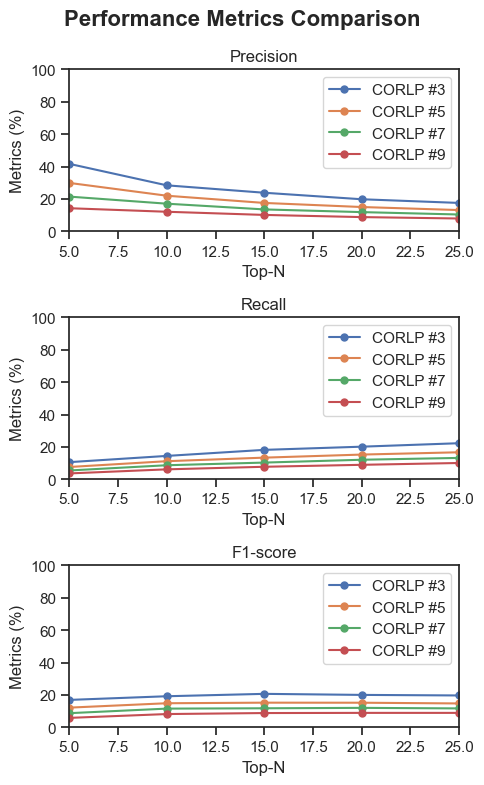

In [124]:
sns.set(style="ticks")

x = np.arange(5, 30, 5)

# Create a single column of subplots
fig, axs = plt.subplots(3, 1, figsize=(5, 8))

metrics = {'Precision': 1, 'Recall': 2, 'F1-score': 3}

for i, (label, metric_index) in enumerate(metrics.items()):
    y = []
    for key, value in test_results_a.items():
        y_per_metric = [metric[metric_index] * 100 for metric in value]
        y.append(y_per_metric)

    for j, y_values in enumerate(y):
        axs[i].plot(x, y_values, marker='o', markersize=5, label=f"CORLP #{list(test_results_a.keys())[j]}")

    axs[i].set_title(label)
    axs[i].set_xlabel("Top-N")
    axs[i].set_ylabel("Metrics (%)")
    axs[i].set_xlim(x.min(), x.max())
    axs[i].set_ylim(0, 100)
    axs[i].legend()

plt.suptitle('Performance Metrics Comparison', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# Enhance performance by incorporating playlist similarity and track similarity.

In [45]:
from surprise import Reader, Dataset, SVD
from sklearn.metrics.pairwise import cosine_similarity

In [46]:
reader = Reader()

data = Dataset.load_from_df(df_train[['playlistId', 'trackId', 'weight']], reader)
train_set = data.build_full_trainset()

svd = SVD(n_factors=2)
trained_data = svd.fit(train_set)

pu = trained_data.pu # user factors
qi = trained_data.qi # item factors

In [47]:
cos_threshold = 0.5

# finding similarities between users
pu_similarities = cosine_similarity(pu)

pu_similarities[pu_similarities >= cos_threshold] =  1
pu_similarities[pu_similarities <  cos_threshold] = -1

Auu = pu_similarities

# finding similarities between items
qi_similarities = cosine_similarity(qi)

qi_similarities[qi_similarities >= cos_threshold] =  1
qi_similarities[qi_similarities <  cos_threshold] = -1

Aii = qi_similarities

B = np.vstack([np.hstack([Auu, Aui]), 
               np.hstack([Aiu, Aii])])

In [48]:
powers_of_B = calculate_matrix_power_of(B)

In [99]:
test_results = {}

number_of_recommended_item = np.arange(5, 30, 5) 

power = 3
for B in tqdm(powers_of_B):
  for N in tqdm(number_of_recommended_item):
    
    result = test_recommender_system(B, N)
    
    if power in test_results:
      test_results[power].append(result)
    else:
      test_results[power] = [result]
  
  power += 2

100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


In [103]:
test_results_b = test_results

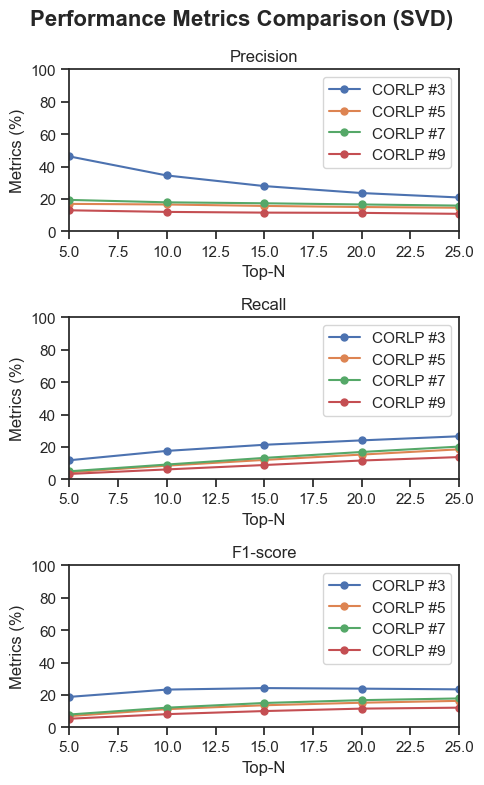

In [122]:
sns.set(style="ticks")

x = np.arange(5, 30, 5)

# Create a single column of subplots
fig, axs = plt.subplots(3, 1, figsize=(5, 8))

metrics = {'Precision': 1, 'Recall': 2, 'F1-score': 3}

for i, (label, metric_index) in enumerate(metrics.items()):
    y = []
    for key, value in test_results_b.items():
        y_per_metric = [metric[metric_index] * 100 for metric in value]
        y.append(y_per_metric)

    for j, y_values in enumerate(y):
        axs[i].plot(x, y_values, marker='o', markersize=5, label=f"CORLP #{list(test_results_b.keys())[j]}")

    axs[i].set_title(label)
    axs[i].set_xlabel("Top-N")
    axs[i].set_ylabel("Metrics (%)")
    axs[i].set_xlim(x.min(), x.max())
    axs[i].set_ylim(0, 100)
    axs[i].legend()

plt.suptitle('Performance Metrics Comparison (SVD)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# Testing SVD++ instead of simple SVD

In [61]:
from surprise import Reader, Dataset, SVDpp
from sklearn.metrics.pairwise import cosine_similarity

In [62]:
reader = Reader()

data = Dataset.load_from_df(df_train[['playlistId', 'trackId', 'weight']], reader)
train_set = data.build_full_trainset()

svd = SVDpp(n_factors=2)
trained_data = svd.fit(train_set)

pu = trained_data.pu # user factors
qi = trained_data.qi # item factors

In [63]:
cos_threshold = 0.5

# finding similarities between users
pu_similarities = cosine_similarity(pu)

pu_similarities[pu_similarities >= cos_threshold] =  1
pu_similarities[pu_similarities <  cos_threshold] = -1

Auu = pu_similarities

# finding similarities between items
qi_similarities = cosine_similarity(qi)

qi_similarities[qi_similarities >= cos_threshold] =  1
qi_similarities[qi_similarities <  cos_threshold] = -1

Aii = qi_similarities

C = np.vstack([np.hstack([Auu, Aui]), 
               np.hstack([Aiu, Aii])])

In [66]:
powers_of_C = calculate_matrix_power_of(C)

In [126]:
test_results = {}

number_of_recommended_item = np.arange(5, 30, 5)

power = 3
for C in tqdm(powers_of_C):
  for N in tqdm(number_of_recommended_item):
    
    result = test_recommender_system(C, N)
    
    if power in test_results:
      test_results[power].append(result)
    else:
      test_results[power] = [result]

  power += 2

100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


In [127]:
test_results_c = test_results

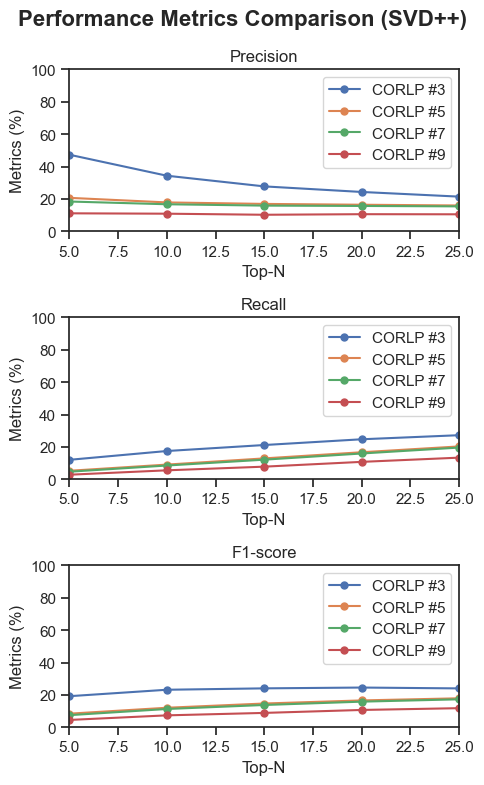

In [128]:
sns.set(style="ticks")

x = np.arange(5, 30, 5)

fig, axs = plt.subplots(3, 1, figsize=(5, 8))

metrics = {'Precision': 1, 'Recall': 2, 'F1-score': 3}

for i, (label, metric_index) in enumerate(metrics.items()):
    y = []
    for key, value in test_results_c.items():
        y_per_metric = [metric[metric_index] * 100 for metric in value]
        y.append(y_per_metric)

    for j, y_values in enumerate(y):
        axs[i].plot(x, y_values, marker='o', markersize=5, label=f"CORLP #{list(test_results_c.keys())[j]}")

    axs[i].set_title(label)
    axs[i].set_xlabel("Top-N")
    axs[i].set_ylabel("Metrics (%)")
    axs[i].set_xlim(x.min(), x.max())
    axs[i].set_ylim(0, 100)
    axs[i].legend()

plt.suptitle('Performance Metrics Comparison (SVD++)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()
